In [1]:
# %pip install braindecode mne umap-learn skorch==0.10.0
# %pip install umap-learn[plot] pandas matplotlib datashader bokeh holoviews scikit-image colorcet

# imports
import os
import importlib
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import mne
import torch
from torch import nn
from torch.utils.data import DataLoader
from braindecode.datasets.sleep_physionet import SleepPhysionet
from braindecode.datasets import BaseConcatDataset
from braindecode.datautil.preprocess import preprocess, Preprocessor
from braindecode.preprocessing.windowers import create_windows_from_events
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerChambon2018
from braindecode import EEGClassifier
from braindecode.datautil.preprocess import zscore
from braindecode.samplers.ssl import RelativePositioningSampler
from braindecode.datasets import (create_from_mne_raw, create_from_mne_epochs)

from sklearn.model_selection import train_test_split
from skorch.helper import predefined_split
from skorch.callbacks import Checkpoint, EarlyStopping, EpochScoring
from skorch.utils import to_tensor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# visualizations

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import learning_curve
from matplotlib import cm
import umap.umap_ as umap
import umap.plot

from umap import UMAP
import plotly.express as px

# ----


# classes
from helper_funcs import HelperFuncs as hf
from ContrastiveNet import *
from RelativePositioningDataset import *
from plot import Plot

from tqdm import tqdm

# Authors: Hubert Banville <hubert.jbanville@gmail.com>
#
# License: BSD (3-clause)


random_state = 87
n_jobs = 1
batch_size = 256
sfreq = 100
n_epochs = 25
n_classes = 5
cv = 5
n_epochs = 5
lr = 5e-3

/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/braindecode/datautil/preprocess.py:10: UserWarning: datautil.preprocess module is deprecated and is now under preprocessing.preprocess, please use from import braindecode.preprocessing.preprocess
  warn('datautil.preprocess module is deprecated and is now under '


Loading data, preprocessing, and windowing

In [2]:
dataset = SleepPhysionet(
    subject_ids=[*range(5)],
    recording_ids=[1],
    crop_wake_mins=30,
    load_eeg_only=True,
    sfreq=sfreq
)

high_cut_hz = 30

preprocessors = [
    Preprocessor(lambda x: x * 1e6), # convert to microvolts
    Preprocessor('filter', l_freq=None, h_freq=high_cut_hz, n_jobs=n_jobs) # high pass filtering
]

# Transform the data
preprocess(dataset, preprocessors)

# change to 5 second windows
window_size_s = 5
sfreq = 100
# window_size_samples = window_size_s * sfreq
window_size_samples = 500

mapping = {  # We merge stages 3 and 4 following AASM standards.
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4
}

windows_dataset = create_windows_from_events(
    dataset, trial_start_offset_samples=0, trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples, preload=True, mapping=mapping)

preprocess(windows_dataset, [Preprocessor(zscore)])

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2508000  =      0.000 ... 25080.000 sec

/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/braindecode/preprocessing/preprocess.py:52: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 3261000  =      0.000 ... 32610.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 3060000  =      0.000 

/home/maligan/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function zscore is deprecated; will be removed in 0.7.0. Use sklearn.preprocessing.scale instead.
  warnings.warn(msg, category=FutureWarning)


In [183]:
subjects = np.unique(windows_dataset.description['subject'])
subj_train, subj_test = train_test_split(
    subjects, test_size=0.4, random_state=random_state)
subj_valid, subj_test = train_test_split(
    subj_test, test_size=0.5, random_state=random_state)


split_ids = {'train': subj_train, 'valid': subj_valid, 'test': subj_test}
splitted = dict()
for name, values in split_ids.items():
    splitted[name] = RelativePositioningDataset(
        [ds for ds in windows_dataset.datasets
         if ds.description['subject'] in values])


# obtain X and y data from datasets
# nn_set, loader = dict(), dict()
# for name, split in splitted.items():
#     _set = []
#     split.return_pair = False
#     for ds in split.datasets:
#         for window in ds:
#             _set += [window[0:2]]
            
#     nn_set[name] = _set
#     loader[name] = DataLoader(nn_set[name], batch_size=1, num_workers=1, shuffle=True)

# dataiter = iter(loader['train'])
# train_data, labels = dataiter.next()

In [184]:
num_workers = 1
batch_size = 256
desc = None

# fetch pretrained model
ssl_model = torch.load("models/pretrained/2021_12_16__10_23_49_sleep_staging_5s_windows_83_subjects_cpu_15_epochs_100hz.model")

# Extract features with the trained embedder
dataset = []
data, raw_data, descriptions = dict(), dict(), dict()
for name, split in splitted.items():
    split.return_pair = False  # Return single windows
    loader = DataLoader(split, batch_size=batch_size, num_workers=num_workers)
    with torch.no_grad():
        feats = [ssl_model.emb(batch_x.to(device)).cpu().numpy() for batch_x, _, _ in loader]
        # make a copy of the vectors WITHOUT passing them through the pretrained model
        raw_vectors = [batch_x.to(device).cpu().numpy() for batch_x, _, _ in loader]
    # descriptions values according to dataset in use: CHANGE MANUALLY
    if desc is not None:
        descriptions[name] = split.get_metadata()[desc].values  
    data[name] = (np.concatenate(feats), split.get_metadata()['target'].values)
    # concatenate channels per window such that you will have 10s windows
    raw_data[name] = ([np.concatenate(x.T) for x in np.concatenate(raw_vectors)], split.get_metadata()['target'].values)
    # add data and targets to [dataset]
    for ds in split.datasets:
        for window in ds:
            dataset += [window[0:2]]

# combine all vectors (X) and labels (y) from DATA sets
X = np.concatenate([v[0] for k, v in data.items()])
y = np.concatenate([v[1] for k, v in data.items()])
if desc is not None:
    desc = np.concatenate([v for k, v in descriptions.items()])

In [185]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to reproduce results
set_random_seeds(seed=random_state, cuda=device == 'cuda')

# Extract number of channels and time steps from dataset
n_channels, input_size_samples = windows_dataset[0][0].shape
emb_size = sfreq

fs_model = SleepStagerChambon2018(
    n_channels,
    sfreq,
    n_classes=n_classes,
    n_conv_chs=16,
    input_size_s=input_size_samples / sfreq,
    dropout=0,
    apply_batch_norm=True
)

In [186]:
fs_model

SleepStagerChambon2018(
  (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
  (feature_extractor): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 16, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=96, out_features=5, bias=True)
  )
)

In [188]:
import torch.optim as optim
from sklearn.model_selection import KFold

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fs_model.parameters(), lr=lr, momentum=0.9)

# 5-fold cross-validation
kfold = KFold(n_splits=cv, shuffle=True, random_state=42)

In [187]:
def reset_weights(m):
	'''
		Try resetting model weights to avoid
		weight leakage.
	'''
	for layer in m.children():
		if hasattr(layer, 'reset_parameters'):
			# print(f'Reset trainable parameters of layer = {layer}')
			layer.reset_parameters()

# confusion matrix
def conf_matrix_class_report(model, dataloader, n_classes):
		confusion_matrix = torch.zeros(n_classes, n_classes)
		y_pred = []
		y_true = []
		with torch.no_grad():
			for i, (inputs, labels) in enumerate(dataloader):
				inputs = inputs.to(device)
				labels = labels.to(device)
				outputs = model(inputs)
				_, preds = torch.max(outputs, 1)
				for t, p in zip(labels.view(-1), preds.view(-1)):
								confusion_matrix[t, p] += 1
				y_pred += [preds]
				y_true += [labels]

		y_pred = np.concatenate(y_pred)
		y_true = np.concatenate(y_true)

		class_report = classification_report(y_true=y_true, y_pred=y_pred)

		torch.set_printoptions(sci_mode=False)
		return confusion_matrix, class_report

In [ ]:
# results = {}

# # K-fold Cross Validation model evaluation
# for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
# 	# Print
# 	print(f'FOLD {fold}')
# 	print('--------------------------------')
	
# 	# Sample elements randomly from a given list of ids, no replacement.
# 	train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
# 	test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
	
# 	# Define data loaders for training and testing data in this fold
# 	trainloader = DataLoader(dataset, batch_size=5, sampler=train_subsampler)
# 	testloader = DataLoader(dataset, batch_size=5, sampler=test_subsampler)

# 	# Init the neural network
# 	print('Resetting trainable parameters...')
# 	fs_model.apply(reset_weights)
	
# 	# Run the training loop for defined number of epochs
# 	for epoch in range(5):
# 		print(f'Epoch {epoch+1}')
# 		# Set current loss value
# 		running_loss = 0.0

# 		# Iterate over the DataLoader for training data
# 		for i, data in enumerate(tqdm(trainloader, 0)):
# 			# Get inputs
# 			inputs, targets = data
			
# 			# Zero the gradients
# 			optimizer.zero_grad()
			
# 			# Perform forward pass
# 			outputs = fs_model(inputs)
# 			# Compute loss
# 			loss = criterion(outputs, targets)
# 			# Perform backward pass
# 			loss.backward()
# 			# Perform optimization
# 			optimizer.step()
			
# 			# Print statistics
# 			running_loss += loss.item()
# 			# if i % 25 == 24:
# 		print('Loss after mini-batch %5d: %.3f' % (i + 1, running_loss))
# 		running_loss = 0.0
					
# 	# Process is complete.
# 	print('Training process has finished. Saving trained model.')

# 	# Print about testing
# 	print('Starting testing')
	
# 	# Saving the model
# 	save_path = f'./model-fold-{fold}.pth'
# 	torch.save(fs_model.state_dict(), save_path)

# 	# Evaluation for this fold
# 	correct, total = 0, 0
# 	with torch.no_grad():
# 		# Iterate over the test data and generate predictions
# 		for i, data in enumerate(testloader, 0):

# 			# Get inputs
# 			inputs, targets = data

# 			# Generate outputs
# 			outputs = fs_model(inputs)

# 			# Set total and correct
# 			_, predicted = torch.max(outputs.data, 1)
# 			total += targets.size(0)
# 			correct += (predicted == targets).sum().item()

# 		bal_acc = balanced_accuracy_score(y_pred=predicted, y_true=targets)

# 		# Print accuracy
#       	# print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
# 		print(f'Balanced Accuracy for fold {bal_acc}')
# 		print('--------------------------------')
# 		results[fold] = bal_acc
# 	break

# # Print fold results
# print(f'K-FOLD CROSS VALIDATION RESULTS FOR {cv} FOLDS')
# print('--------------------------------')
# sum = 0.0
# for key, value in results.items():
# 	print(f'Fold {key}: {value} %')
# 	sum += value
# print(f'Average: {sum/len(results.items())} %')

In [ ]:
matrix, report = conf_matrix_class_report(fs_model, loader['test'], n_classes)
print(matrix)
print(report)

In [261]:
input, label = next(iter(loader['test']))
output = fs_model(input)

In [ ]:
labels = []
for x in loader['train']:
    labels += [x[-1]]
np.unique(labels)

In [175]:
# dataset = np.concatenate([v for k,v in nn_set.items()])

space = np.linspace(0,1,4)
results = []
train_sizes = []
batch_size = 5

# 5-fold cross-validation
kfold = KFold(n_splits=2, shuffle=True, random_state=42)

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    # Define data loaders for training and testing data in this fold
    trainloader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    testloader = DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)

    train_space = np.round(space * len(train_ids))
    test_space = np.round(space * len(test_ids))
    
    print(f"n training examples: {len(trainloader)}\
        \ntrain_space intervals: {train_space}\
        \ntest_space intervals: {test_space}")

    epoch_bal_acc = []

    # for epoch in range(n_epochs):
    for epoch in range(3):
        count = 0
        count_space = 0
        running_loss = 0.0
        bal_acc = []

        for i, data in enumerate(tqdm(trainloader)):

            count += 1
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = fs_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # test per batch
            if i*batch_size >= train_space[count_space]:
                if fold == 0:
                    train_sizes += [i*batch_size]
                correct = 0
                total = 0
                y_true = []
                y_pred = []
                count_space += 1
                with torch.no_grad():
                    for _i, data in enumerate(testloader):
                        inputs, labels = data
                        outputs = fs_model(inputs)
                        # the class with the highest energy is what we choose as prediction
                        _, predicted = torch.max(outputs.data, 1)
                        y_true += [labels]
                        y_pred += [predicted]
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                    y_true = np.concatenate(y_true)
                    y_pred = np.concatenate(y_pred)
                _bal_acc = balanced_accuracy_score(y_true, y_pred)
                bal_acc += [_bal_acc]
                print(f'Space index: #{count_space-1}\
                    \ntrain|test space size: {train_space[count_space]}|{test_space[count_space]}\
                    \nrunning loss: {running_loss}\
                    \nbal_acc --> {_bal_acc}')
                # print(f'#{count_space} [{i}|{test_space[count_space]}] ---> {balanced_accuracy_score(y_true, y_pred)}')
                # print(f'[{epoch + 1}] loss: {loss.item()} | running_loss: {running_loss})')
                running_loss = 0.0
            epoch_bal_acc += [bal_acc]
                
        fold_bal_acc += [epoch_bal_acc]

    print('Finished Training')

FOLD 0
--------------------------------
n training examples: 4103        
train_space intervals: [    0.  6837. 13674. 20511.]        
test_space intervals: [    0.  3419.  6837. 10256.]


  0%|          | 8/4103 [00:11<1:10:14,  1.03s/it] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.211753249168396                    
bal_acc --> 0.7369663132209348


 34%|███▎      | 1375/4103 [00:54<13:49,  3.29it/s]

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 756.785045819357                    
bal_acc --> 0.7145473096783386


 67%|██████▋   | 2746/4103 [01:38<08:05,  2.79it/s]

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 731.8252023747191                    
bal_acc --> 0.7348145691057149


  0%|          | 7/4103 [00:09<1:08:39,  1.01s/it] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.5413296222686768                    
bal_acc --> 0.6960099542623925


 34%|███▎      | 1379/4103 [00:53<17:42,  2.56it/s]

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 722.2683610226959                    
bal_acc --> 0.7126515732546503


 67%|██████▋   | 2741/4103 [01:40<10:15,  2.21it/s]

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 738.5003493353724                    
bal_acc --> 0.6553465195724741


  0%|          | 7/4103 [00:10<1:16:51,  1.13s/it] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 1.2214564085006714                    
bal_acc --> 0.7129611590929958


 33%|███▎      | 1374/4103 [00:53<18:40,  2.43it/s]

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 711.9309069709852                    
bal_acc --> 0.6604576027526978


 67%|██████▋   | 2746/4103 [01:36<09:27,  2.39it/s]

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 735.8570626601577                    
bal_acc --> 0.721328745470434


  0%|          | 8/4103 [00:09<1:02:13,  1.10it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.19663892686367035                    
bal_acc --> 0.6932281008337279


 33%|███▎      | 1374/4103 [00:49<18:10,  2.50it/s]

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 713.0770901218057                    
bal_acc --> 0.6887944607983646


 67%|██████▋   | 2742/4103 [01:30<10:36,  2.14it/s]

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 711.3114056903869                    
bal_acc --> 0.7281318727828074


  0%|          | 8/4103 [00:10<1:04:46,  1.05it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.2881799340248108                    
bal_acc --> 0.7173526377847044


 34%|███▎      | 1375/4103 [00:49<16:43,  2.72it/s]

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 686.2958731306717                    
bal_acc --> 0.6779401280558982


 67%|██████▋   | 2744/4103 [01:31<08:28,  2.67it/s]

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 716.0259579773992                    
bal_acc --> 0.6829601343887967


  0%|          | 12/4103 [00:06<28:07,  2.42it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.13327829539775848                    
bal_acc --> 0.7224190052753929


 34%|███▎      | 1384/4103 [00:25<05:16,  8.59it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 665.5068270759657                    
bal_acc --> 0.6856974678435593


 67%|██████▋   | 2754/4103 [00:42<01:43, 13.04it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 704.3447846826166                    
bal_acc --> 0.7303204171750425


  0%|          | 13/4103 [00:04<17:51,  3.82it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.3654383718967438                    
bal_acc --> 0.713573342283723


 34%|███▍      | 1397/4103 [00:19<03:05, 14.57it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 684.0106925764121                    
bal_acc --> 0.6760119453191177


 67%|██████▋   | 2758/4103 [00:34<01:50, 12.19it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 687.257087492384                    
bal_acc --> 0.6571029651954159


  0%|          | 14/4103 [00:04<17:19,  3.93it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.33614295721054077                    
bal_acc --> 0.7281362559996517


 34%|███▍      | 1397/4103 [00:19<03:18, 13.66it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 659.2646824261174                    
bal_acc --> 0.7146038245764205


 67%|██████▋   | 2751/4103 [00:34<01:42, 13.22it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 690.4713419154286                    
bal_acc --> 0.7182511285581836


  0%|          | 16/4103 [00:05<15:23,  4.43it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.15239210426807404                    
bal_acc --> 0.6932020540416131


 34%|███▍      | 1387/4103 [00:19<03:10, 14.29it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 626.9925411501899                    
bal_acc --> 0.6936348890474469


 67%|██████▋   | 2759/4103 [00:34<01:48, 12.34it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 684.8566859313287                    
bal_acc --> 0.7011360415122928


  0%|          | 12/4103 [00:04<18:23,  3.71it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.10942450910806656                    
bal_acc --> 0.6601033417154915


 34%|███▍      | 1390/4103 [00:19<03:34, 12.65it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 643.284822515212                    
bal_acc --> 0.6963891496468603


 67%|██████▋   | 2760/4103 [00:34<01:45, 12.71it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 686.9628053028136                    
bal_acc --> 0.6884408752239395


  0%|          | 13/4103 [00:05<19:42,  3.46it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 1.7919280529022217                    
bal_acc --> 0.6896385074779513


 34%|███▍      | 1387/4103 [00:20<03:11, 14.16it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 623.8133805114776                    
bal_acc --> 0.699158346175693


 67%|██████▋   | 2750/4103 [00:34<01:46, 12.74it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 628.8666731971316                    
bal_acc --> 0.6905324383818893


  0%|          | 15/4103 [00:04<15:20,  4.44it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.18321511149406433                    
bal_acc --> 0.6617200758709135


 34%|███▍      | 1389/4103 [00:20<03:45, 12.05it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 639.9904235817958                    
bal_acc --> 0.7127190360270814


 67%|██████▋   | 2759/4103 [00:35<01:37, 13.75it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 639.133813649416                    
bal_acc --> 0.6956576478653743


  0%|          | 16/4103 [00:05<15:37,  4.36it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.43374377489089966                    
bal_acc --> 0.6898169080680967


 34%|███▍      | 1385/4103 [00:19<03:26, 13.19it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 609.4363637194037                    
bal_acc --> 0.6944593581496965


 67%|██████▋   | 2758/4103 [00:35<02:04, 10.77it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 630.1905324072577                    
bal_acc --> 0.7086605383682903


  0%|          | 12/4103 [00:04<19:30,  3.50it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 1.7345850467681885                    
bal_acc --> 0.6968789716733943


 34%|███▍      | 1390/4103 [00:19<03:21, 13.48it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 585.7985689304769                    
bal_acc --> 0.6927571988335967


 67%|██████▋   | 2758/4103 [00:34<01:39, 13.50it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 638.0526742786169                    
bal_acc --> 0.7139198233835674


  0%|          | 14/4103 [00:05<18:59,  3.59it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.7014917731285095                    
bal_acc --> 0.6757251424536428


 34%|███▎      | 1383/4103 [00:20<03:21, 13.47it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 588.5325492080301                    
bal_acc --> 0.7183993022392147


 67%|██████▋   | 2754/4103 [00:36<01:56, 11.54it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 612.0337487459183                    
bal_acc --> 0.6821789164497704


100%|██████████| 4103/4103 [00:47<00:00, 87.04it/s] 


Finished Training
FOLD 1
--------------------------------
n training examples: 4103        
train_space intervals: [    0.  6837. 13674. 20511.]        
test_space intervals: [    0.  3419.  6837. 10256.]


  0%|          | 16/4103 [00:04<13:54,  4.90it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.05201251059770584                    
bal_acc --> 0.7813671487514945


 34%|███▍      | 1389/4103 [00:19<03:26, 13.13it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 746.2994859386235                    
bal_acc --> 0.7739702268009333


 67%|██████▋   | 2755/4103 [00:34<01:37, 13.85it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 766.9190860278904                    
bal_acc --> 0.77566062875701


  0%|          | 13/4103 [00:04<17:30,  3.89it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.6355868577957153                    
bal_acc --> 0.7483173919646644


 34%|███▍      | 1387/4103 [00:19<03:17, 13.76it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 705.752718327567                    
bal_acc --> 0.7631365132929437


 67%|██████▋   | 2759/4103 [00:34<01:49, 12.31it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 695.198952421546                    
bal_acc --> 0.765734366475638


  0%|          | 13/4103 [00:04<17:16,  3.95it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.3407401144504547                    
bal_acc --> 0.7604198470989629


 34%|███▍      | 1391/4103 [00:19<03:40, 12.30it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 674.7601136052981                    
bal_acc --> 0.7385727596744767


 67%|██████▋   | 2752/4103 [00:34<01:37, 13.80it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 710.0156402401626                    
bal_acc --> 0.7924717196323481


  0%|          | 15/4103 [00:05<16:43,  4.07it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.1357884407043457                    
bal_acc --> 0.7662743911348007


 34%|███▍      | 1388/4103 [00:20<03:28, 13.02it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 680.1573321921751                    
bal_acc --> 0.7479010165451417


 67%|██████▋   | 2753/4103 [00:35<01:46, 12.66it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 659.3649280518293                    
bal_acc --> 0.7662428902299817


  0%|          | 15/4103 [00:04<15:22,  4.43it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.18956413865089417                    
bal_acc --> 0.7661378691891867


 34%|███▍      | 1387/4103 [00:19<03:29, 12.97it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 662.5958323832601                    
bal_acc --> 0.7134544002503146


 67%|██████▋   | 2764/4103 [00:34<01:29, 14.95it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 655.8486945116892                    
bal_acc --> 0.7764217489316392


  0%|          | 13/4103 [00:04<17:06,  3.98it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.40366631746292114                    
bal_acc --> 0.7149917240764584


 34%|███▍      | 1394/4103 [00:19<03:05, 14.60it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 640.5911657530814                    
bal_acc --> 0.7707734440035148


 67%|██████▋   | 2760/4103 [00:35<01:44, 12.85it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 679.5104009611532                    
bal_acc --> 0.7692146865413528


  0%|          | 16/4103 [00:04<13:50,  4.92it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.1354580819606781                    
bal_acc --> 0.7717600645151015


 34%|███▍      | 1391/4103 [00:21<03:24, 13.23it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 627.9664941402152                    
bal_acc --> 0.7576711718254286


 67%|██████▋   | 2758/4103 [00:36<01:41, 13.29it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 653.4620614079759                    
bal_acc --> 0.7194596704400464


  0%|          | 15/4103 [00:05<17:07,  3.98it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.12059495598077774                    
bal_acc --> 0.7225198185529045


 34%|███▍      | 1392/4103 [00:20<03:32, 12.77it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 638.743868467398                    
bal_acc --> 0.7513680696166821


 67%|██████▋   | 2750/4103 [00:34<01:55, 11.71it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 627.0106631731614                    
bal_acc --> 0.7477113279060862


  0%|          | 16/4103 [00:04<13:56,  4.88it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.36469265818595886                    
bal_acc --> 0.7118643300496629


 34%|███▎      | 1383/4103 [00:20<05:29,  8.25it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 605.5118559030816                    
bal_acc --> 0.7190067455434642


 67%|██████▋   | 2743/4103 [01:13<11:06,  2.04it/s]

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 618.8236162280664                    
bal_acc --> 0.7415391266063699


  0%|          | 10/4103 [00:10<53:15,  1.28it/s]  

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.6556748151779175                    
bal_acc --> 0.7408961454744257


 34%|███▎      | 1377/4103 [01:03<22:38,  2.01it/s]

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 610.0214561698958                    
bal_acc --> 0.7294547170501139


 67%|██████▋   | 2741/4103 [01:55<10:57,  2.07it/s]

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 577.3911439930089                    
bal_acc --> 0.7424399494267051


  0%|          | 7/4103 [00:11<1:23:05,  1.22s/it] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.12136182934045792                    
bal_acc --> 0.7450399824548782


 33%|███▎      | 1374/4103 [01:02<25:42,  1.77it/s]

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 590.8842174890451                    
bal_acc --> 0.7422513328920705


 67%|██████▋   | 2745/4103 [01:51<11:16,  2.01it/s]

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 603.0326512306929                    
bal_acc --> 0.7303029584857369


  0%|          | 6/4103 [00:11<1:33:22,  1.37s/it] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.09991317987442017                    
bal_acc --> 0.7307454845764382


 34%|███▎      | 1378/4103 [00:59<21:02,  2.16it/s]

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 616.2329809204675                    
bal_acc --> 0.6915558471312023


 67%|██████▋   | 2746/4103 [01:52<08:53,  2.54it/s]

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 575.1776366122067                    
bal_acc --> 0.7102319948195813


  0%|          | 8/4103 [00:11<1:14:14,  1.09s/it] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.7370330691337585                    
bal_acc --> 0.7305013503440156


 34%|███▎      | 1376/4103 [01:04<18:43,  2.43it/s]

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 598.7146360073239                    
bal_acc --> 0.7229364984534081


 67%|██████▋   | 2754/4103 [01:40<01:34, 14.28it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 594.1187904812396                    
bal_acc --> 0.6948746253745168


  0%|          | 13/4103 [00:04<17:22,  3.92it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.25274085998535156                    
bal_acc --> 0.7178225962390662


 34%|███▍      | 1393/4103 [00:19<03:32, 12.78it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 542.0322975059971                    
bal_acc --> 0.7265250810344202


 67%|██████▋   | 2763/4103 [00:34<01:36, 13.90it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 594.2495665918104                    
bal_acc --> 0.7123060109741024


  0%|          | 14/4103 [00:04<16:33,  4.12it/s] 

Space index: #0                    
train|test space size: 6837.0|3419.0                    
running loss: 0.31662553548812866                    
bal_acc --> 0.7305577315083214


 34%|███▎      | 1378/4103 [00:19<03:53, 11.68it/s] 

Space index: #1                    
train|test space size: 13674.0|6837.0                    
running loss: 555.428161512129                    
bal_acc --> 0.7203507250296936


 67%|██████▋   | 2751/4103 [00:34<01:50, 12.18it/s] 

Space index: #2                    
train|test space size: 20511.0|10256.0                    
running loss: 576.6516622784548                    
bal_acc --> 0.6967915386834637


100%|██████████| 4103/4103 [00:45<00:00, 89.44it/s] 


Finished Training
FOLD 2
--------------------------------
n training examples: 4103        
train_space intervals: [    0.  6837. 13675. 20512.]        
test_space intervals: [    0.  3418.  6837. 10255.]


  0%|          | 16/4103 [00:04<13:58,  4.88it/s] 

Space index: #0                    
train|test space size: 6837.0|3418.0                    
running loss: 0.49506473541259766                    
bal_acc --> 0.8571861502077027


 34%|███▍      | 1389/4103 [00:19<03:05, 14.63it/s] 

Space index: #1                    
train|test space size: 13675.0|6837.0                    
running loss: 702.2640033047646                    
bal_acc --> 0.7621060220444567


 67%|██████▋   | 2757/4103 [00:34<01:52, 11.98it/s] 

Space index: #2                    
train|test space size: 20512.0|10255.0                    
running loss: 711.7026643157005                    
bal_acc --> 0.8020697126777495


  0%|          | 17/4103 [00:04<13:18,  5.11it/s] 

Space index: #0                    
train|test space size: 6837.0|3418.0                    
running loss: 0.5503241419792175                    
bal_acc --> 0.7873590912281243


 34%|███▍      | 1387/4103 [00:19<03:19, 13.60it/s] 

Space index: #1                    
train|test space size: 13675.0|6837.0                    
running loss: 664.4248627601191                    
bal_acc --> 0.7776814272662806


 67%|██████▋   | 2760/4103 [00:34<01:32, 14.47it/s] 

Space index: #2                    
train|test space size: 20512.0|10255.0                    
running loss: 675.6640369696543                    
bal_acc --> 0.7871209732555876


  0%|          | 13/4103 [00:05<19:48,  3.44it/s] 

Space index: #0                    
train|test space size: 6837.0|3418.0                    
running loss: 0.5686624646186829                    
bal_acc --> 0.7868047226197055


 34%|███▎      | 1384/4103 [00:20<03:18, 13.68it/s] 

Space index: #1                    
train|test space size: 13675.0|6837.0                    
running loss: 642.0489202328026                    
bal_acc --> 0.7969881252969157


 67%|██████▋   | 2760/4103 [00:35<01:51, 12.10it/s] 

Space index: #2                    
train|test space size: 20512.0|10255.0                    
running loss: 632.2973182694986                    
bal_acc --> 0.7791762133790059


  0%|          | 16/4103 [00:04<14:46,  4.61it/s] 

Space index: #0                    
train|test space size: 6837.0|3418.0                    
running loss: 0.7140321731567383                    
bal_acc --> 0.7821835119625108


 34%|███▍      | 1394/4103 [00:20<03:42, 12.15it/s] 

Space index: #1                    
train|test space size: 13675.0|6837.0                    
running loss: 609.1787254563533                    
bal_acc --> 0.7798211217979469


 67%|██████▋   | 2762/4103 [00:34<01:35, 14.07it/s] 

Space index: #2                    
train|test space size: 20512.0|10255.0                    
running loss: 623.729363059625                    
bal_acc --> 0.723279845323019


  0%|          | 16/4103 [00:05<16:21,  4.17it/s] 

Space index: #0                    
train|test space size: 6837.0|3418.0                    
running loss: 0.2816050052642822                    
bal_acc --> 0.7661924449369291


 34%|███▎      | 1380/4103 [00:20<03:58, 11.42it/s] 

Space index: #1                    
train|test space size: 13675.0|6837.0                    
running loss: 617.2542817499489                    
bal_acc --> 0.7452580285112267


 67%|██████▋   | 2764/4103 [00:36<01:40, 13.29it/s] 

Space index: #2                    
train|test space size: 20512.0|10255.0                    
running loss: 623.7458329219371                    
bal_acc --> 0.8049629074263205


  0%|          | 15/4103 [00:04<14:39,  4.65it/s] 

Space index: #0                    
train|test space size: 6837.0|3418.0                    
running loss: 0.3502349555492401                    
bal_acc --> 0.7614057741165372


 34%|███▍      | 1386/4103 [00:19<03:31, 12.82it/s] 

Space index: #1                    
train|test space size: 13675.0|6837.0                    
running loss: 623.5125302765518                    
bal_acc --> 0.7165874466850772


 67%|██████▋   | 2753/4103 [00:34<01:43, 13.10it/s] 

Space index: #2                    
train|test space size: 20512.0|10255.0                    
running loss: 601.8928948999383                    
bal_acc --> 0.7879463648832472


  0%|          | 15/4103 [00:05<17:26,  3.91it/s] 

Space index: #0                    
train|test space size: 6837.0|3418.0                    
running loss: 0.22534628212451935                    
bal_acc --> 0.7806516922983262


 34%|███▍      | 1398/4103 [00:19<03:11, 14.14it/s] 

Space index: #1                    
train|test space size: 13675.0|6837.0                    
running loss: 580.1171300970018                    
bal_acc --> 0.7951336089512235


 67%|██████▋   | 2752/4103 [00:35<01:49, 12.36it/s] 

Space index: #2                    
train|test space size: 20512.0|10255.0                    
running loss: 609.1753389253281                    
bal_acc --> 0.7725613109400715


  0%|          | 16/4103 [00:04<13:49,  4.93it/s] 

Space index: #0                    
train|test space size: 6837.0|3418.0                    
running loss: 0.16887637972831726                    
bal_acc --> 0.7654512397228805


 34%|███▍      | 1392/4103 [00:21<05:00,  9.02it/s] 

Space index: #1                    
train|test space size: 13675.0|6837.0                    
running loss: 596.6344546331093                    
bal_acc --> 0.7530777959341919


 67%|██████▋   | 2754/4103 [00:35<01:30, 14.94it/s] 

Space index: #2                    
train|test space size: 20512.0|10255.0                    
running loss: 595.6905857720412                    
bal_acc --> 0.7424826475063351


  0%|          | 11/4103 [00:05<23:38,  2.88it/s] 

Space index: #0                    
train|test space size: 6837.0|3418.0                    
running loss: 0.4439117908477783                    
bal_acc --> 0.7386400174531107


 34%|███▍      | 1387/4103 [00:19<03:08, 14.40it/s] 

Space index: #1                    
train|test space size: 13675.0|6837.0                    
running loss: 583.5667162071913                    
bal_acc --> 0.7714069820421073


 67%|██████▋   | 2760/4103 [00:34<01:43, 12.98it/s] 

Space index: #2                    
train|test space size: 20512.0|10255.0                    
running loss: 600.7835594406351                    
bal_acc --> 0.7612813116566377


  0%|          | 16/4103 [00:04<14:11,  4.80it/s] 

Space index: #0                    
train|test space size: 6837.0|3418.0                    
running loss: 0.16570520401000977                    
bal_acc --> 0.7286398654504826


 34%|███▍      | 1387/4103 [00:20<03:39, 12.39it/s] 

Space index: #1                    
train|test space size: 13675.0|6837.0                    
running loss: 548.4039626927115                    
bal_acc --> 0.7618562869713316


 67%|██████▋   | 2757/4103 [00:35<01:38, 13.60it/s] 

Space index: #2                    
train|test space size: 20512.0|10255.0                    
running loss: 594.8161334911129                    
bal_acc --> 0.7815359573635965


  0%|          | 13/4103 [00:05<19:08,  3.56it/s] 

Space index: #0                    
train|test space size: 6837.0|3418.0                    
running loss: 0.1761765331029892                    
bal_acc --> 0.7467128226476148


 34%|███▎      | 1381/4103 [00:19<03:24, 13.34it/s] 

Space index: #1                    
train|test space size: 13675.0|6837.0                    
running loss: 557.0797829548828                    
bal_acc --> 0.7450862714633043


 67%|██████▋   | 2761/4103 [00:34<01:29, 15.04it/s] 

Space index: #2                    
train|test space size: 20512.0|10255.0                    
running loss: 563.3527444774518                    
bal_acc --> 0.7370010982237891


  0%|          | 14/4103 [00:04<14:45,  4.62it/s] 

Space index: #0                    
train|test space size: 6837.0|3418.0                    
running loss: 0.04247940331697464                    
bal_acc --> 0.728972307314091


 34%|███▎      | 1383/4103 [00:17<02:56, 15.41it/s] 

Space index: #1                    
train|test space size: 13675.0|6837.0                    
running loss: 545.6789462054148                    
bal_acc --> 0.7617095293255718


 67%|██████▋   | 2752/4103 [00:31<01:23, 16.27it/s] 

Space index: #2                    
train|test space size: 20512.0|10255.0                    
running loss: 564.5443256761646                    
bal_acc --> 0.6975986051766656


  0%|          | 16/4103 [00:04<12:53,  5.28it/s] 

Space index: #0                    
train|test space size: 6837.0|3418.0                    
running loss: 0.134211927652359                    
bal_acc --> 0.6812255853140694


 34%|███▎      | 1384/4103 [00:18<03:03, 14.85it/s] 

Space index: #1                    
train|test space size: 13675.0|6837.0                    
running loss: 538.009453650564                    
bal_acc --> 0.7461684434609822


 67%|██████▋   | 2760/4103 [00:31<01:20, 16.69it/s] 

Space index: #2                    
train|test space size: 20512.0|10255.0                    
running loss: 584.9686025497504                    
bal_acc --> 0.7526006807355422


  0%|          | 18/4103 [00:04<11:28,  5.94it/s] 

Space index: #0                    
train|test space size: 6837.0|3418.0                    
running loss: 0.03164813295006752                    
bal_acc --> 0.7136230013647149


 34%|███▍      | 1385/4103 [00:18<03:00, 15.06it/s] 

Space index: #1                    
train|test space size: 13675.0|6837.0                    
running loss: 532.885809689993                    
bal_acc --> 0.7157560074123679


 67%|██████▋   | 2762/4103 [00:32<01:25, 15.68it/s] 

Space index: #2                    
train|test space size: 20512.0|10255.0                    
running loss: 565.7453654343262                    
bal_acc --> 0.7484806771626471


  0%|          | 14/4103 [00:04<16:09,  4.22it/s] 

Space index: #0                    
train|test space size: 6837.0|3418.0                    
running loss: 0.321463406085968                    
bal_acc --> 0.7355937241142393


 34%|███▎      | 1384/4103 [00:18<02:56, 15.38it/s] 

Space index: #1                    
train|test space size: 13675.0|6837.0                    
running loss: 514.9619012018666                    
bal_acc --> 0.7416323453146545


 67%|██████▋   | 2761/4103 [00:32<01:17, 17.37it/s] 

Space index: #2                    
train|test space size: 20512.0|10255.0                    
running loss: 534.3837796696462                    
bal_acc --> 0.7593496218948296


100%|██████████| 4103/4103 [00:41<00:00, 98.59it/s] 

Finished Training


In [173]:
# from copy import deepcopy
# copy_fold_bal_acc = deepcopy(fold_bal_acc)

In [176]:
matrix, report = conf_matrix_class_report(fs_model, testloader, n_classes)
print(matrix)
print(report)

tensor([[     1315.,       109.,        41.,         3.,        77.],
        [       98.,       440.,       206.,         5.,       165.],
        [       20.,       111.,      4345.,       323.,       192.],
        [        1.,         1.,       204.,       910.,         2.],
        [       28.,       161.,       232.,         1.,      1265.]])
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      1545
           1       0.54      0.48      0.51       914
           2       0.86      0.87      0.87      4991
           3       0.73      0.81      0.77      1118
           4       0.74      0.75      0.75      1687

    accuracy                           0.81     10255
   macro avg       0.76      0.75      0.75     10255
weighted avg       0.81      0.81      0.81     10255



In [120]:
outputs = fs_model(inputs)
torch.max(outputs.data, 1)

torch.return_types.max(
values=tensor([2.2961, 4.9992, 4.9605, 6.7471]),
indices=tensor([1, 4, 4, 2]))

In [37]:
example = next(iter(loader['test']))
inputs, labels = example
outputs = fs_model(inputs)
outputs

tensor([[-2.6006, -2.1025, -0.4791, -4.0898, -0.2418]],
       grad_fn=<AddmmBackward>)

In [134]:
results = np.array(fold_bal_acc)

In [154]:
[len(x) for x in results], len(train_sizes)

([19, 19, 19, 19, 19], 19)

In [181]:
results[0]

array([[0.73696631, 0.71454731, 0.73481457],
       [0.73696631, 0.71454731, 0.73481457],
       [0.73696631, 0.71454731, 0.73481457],
       ...,
       [0.67572514, 0.7183993 , 0.68217892],
       [0.67572514, 0.7183993 , 0.68217892],
       [0.67572514, 0.7183993 , 0.68217892]])

In [177]:
from plot import Plot
p = Plot('test', 'test_string', save=False, show=True)

results = np.array(fold_bal_acc)
p.plot_learning_curves(train_sizes[1:], train_sizes[1:], results.T, results.T, 'fs_cnn_test')

:: plotting learning curves... 

ValueError: 'y1' is not 1-dimensional

In [171]:
# Train pretrained features

ssl_model = nn.Sequential(
    nn.Conv2d(100,30,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(30,10,kernel_size=2,stride=1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    # nn.Flatten(),
    # nn.Linear(256*4*4,1024),
    nn.Softmax(1),
    nn.Linear(10,n_classes)
)
ssl_model


Sequential(
  (0): Conv2d(100, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(30, 10, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Softmax(dim=1)
  (7): Linear(in_features=10, out_features=5, bias=True)
)

In [ ]:
train = DataLoader(X[0], 5, shuffle=True)


In [172]:
ssl_model(X[0])

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


### TESTING

In [180]:
correct = 0
total = 0
y_true = []
y_pred = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(loader['test']):
        inputs, labels = data
        outputs = model(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        y_true += [labels]
        y_pred += [predicted]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# print(f'#\t pred\t true')
# for i in range(len(y_pred)):
#     print(f"{i}\t {y_pred[i]}\t {labels[i]}")

print(f"Accuracy of the network on the {len(nn_set['test'])} test data: {100 * correct // total} %")

Accuracy of the network on the 5017 test data: 13 %


In [147]:
# save model
PATH = './sleep-fs.model'
torch.save(fs_model.state_dict(), PATH)

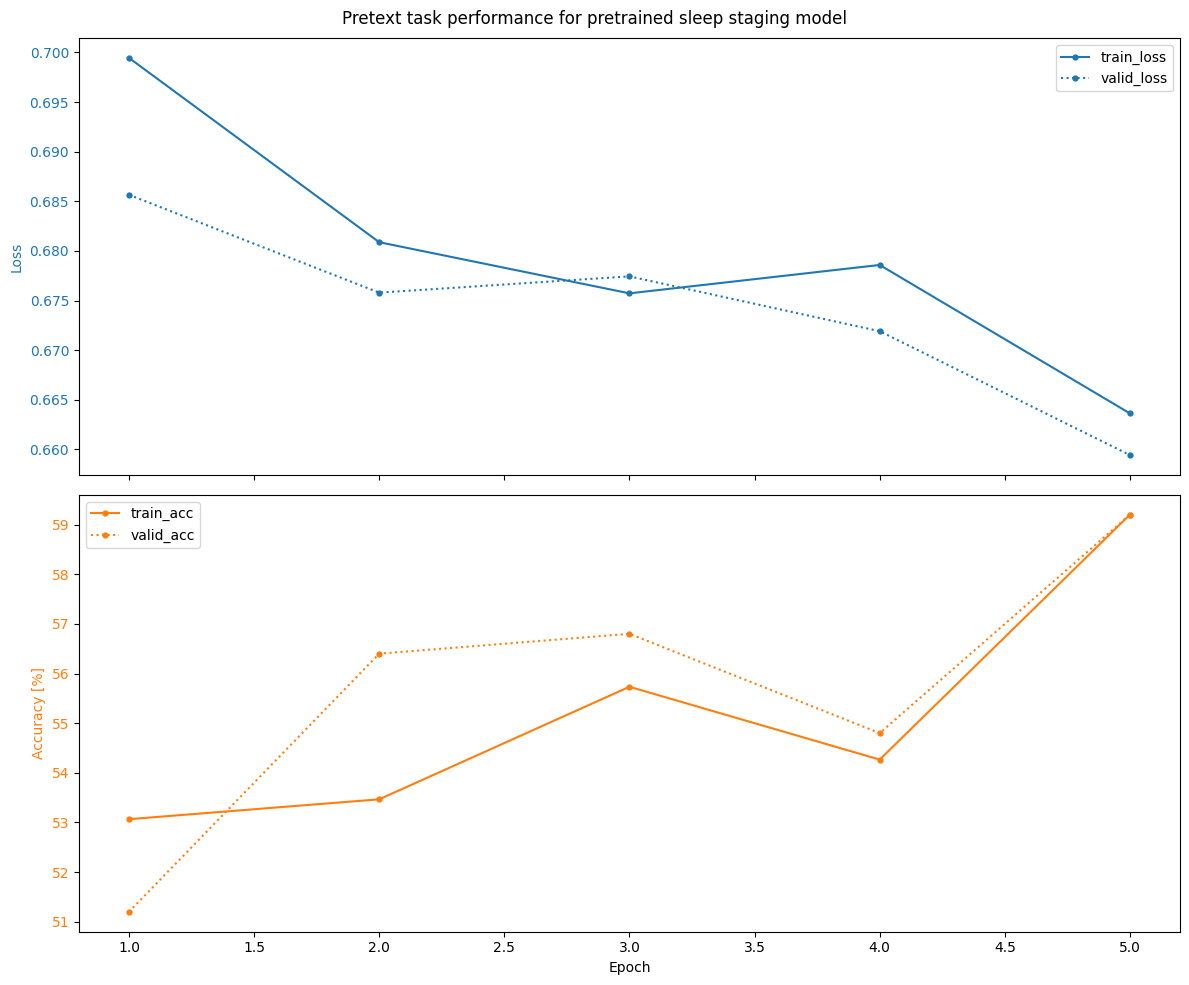

In [11]:
# Extract loss and balanced accuracy values for plotting from history object
df = pd.DataFrame(clf.history.to_list())

df['train_acc'] *= 100
df['valid_acc'] *= 100

ys1 = ['train_loss', 'valid_loss']
ys2 = ['train_acc', 'valid_acc']
styles = ['-', ':']
markers = ['.', '.']


fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

for y1, y2, style, marker in zip(ys1, ys2, styles, markers):
    ax[0].plot(df['epoch'], df[y1], ls=style, marker=marker, ms=7,
             c='tab:blue', label=y1)
    lines1, labels1 = ax[0].get_legend_handles_labels()

    ax[0].tick_params(axis='y', labelcolor='tab:blue')
    ax[0].set_ylabel('Loss', color='tab:blue')
    ax[0].legend(lines1, labels1)

for y1, y2, style, marker in zip(ys1, ys2, styles, markers):
    ax[1].grid()
    ax[1].plot(df['epoch'], df[y2], ls=style, marker=marker, ms=7,
             c='tab:orange', label=y2)

    lines2, labels2 = ax[1].get_legend_handles_labels()

    ax[1].tick_params(axis='y', labelcolor='tab:orange')
    ax[1].set_ylabel('Accuracy [%]', color='tab:orange')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(lines2, labels2)


plt.suptitle('Pretext task performance for pretrained sleep staging model')
plt.tight_layout()
plt.style.use('seaborn-talk')
plt.rc('font', size=16)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)

plt.savefig('sample_pretrain.pdf', format='pdf')
plt.show()
